# DQN: CartPole-v1 con
# Q-Learning y Expended SARSA

 Hoy, nos adentraremos en el fascinante mundo del Aprendizaje por Refuerzo. En este trabajo, nos centraremos en la resolución del problema CartPole-v1, un desafío clásico en el campo de la Inteligencia Artificial.

 Exploraremos dos algoritmos prominentes: Q-Learning y Expended SARSA con DQN . Ambos son métodos de aprendizaje por refuerzo que utilizan la idea de aprender la función de valor de una política, y a través de ella, mejorar nuestras decisiones con el tiempo.

 Nuestro objetivo es comparar estos dos algoritmos y determinar cuál de ellos se desempeña mejor en la tarea de CartPole-v1. Además, investigaremos los diferentes parámetros que necesitamos ajustar para optimizar su rendimiento.

 Espero que esta presentación les brinde una visión clara de cómo estos algoritmos funcionan y cómo pueden ser aplicados para resolver problemas complejos en el campo del Aprendizaje por Refuerzo

### Packages
**En este trabajo, utilizaremos**:
* gym : para proporcionar un entorno de pruebas estándar.
* pickle :  Lo usaremos para cargar datos desde archivos .pkl, que son archivos de  datos serializados por pickle.
* pygame :  para la interfaz gráfica.
* random :  para la generación de números aleatorios.
* matplotlib.pyplot : para la visualización de datos.
* numpy : para cálculos numéricos.
* tqdm : para visualizar el progreso de nuestros experimentos.
* haremos uso de torch, torch.nn, torch.optim y torch.nn.init para construir y entrenar nuestras redes neuronales.


In [2]:
import gym
import pickle
import pygame
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from tqdm import tqdm

### El problema CartPole-V1:

Un poste está unido por una articulación no accionada a un carro, que se mueve a lo largo de una pista sin fricción.
 El sistema se controla aplicando una fuerza de +1 o -1 al carro, para moverse a la izquierda o a la derecha.
El péndulo comienza en posición vertical y el objetivo es evitar que se caiga.
Se proporciona una recompensa de +1 por cada paso de tiempo que el poste permanece en posición vertical.
El episodio termina cuando el poste está a más de 15 grados de la vertical, o el carro se mueve a más de 2.4 unidades del centro

<img src="./img-cartpole/cap1.PNG">

#### QNetwork
QNetwork es una subclase de nn.Module, que es la clase base para todos los módulos de redes neuronales en PyTorch. Esta red neuronal consta de dos capas completamente conectadas (fc1 y fc2), que transforman el estado de entrada en un conjunto de accioness.
Esta red neuronal juega un papel crucial en nuestros algoritmos de Aprendizaje por Refuerzo, ya que nos permite **aproximar la función** de valor Q, que es esencial para la toma de decisiones en Q-Learning y Expended SARSA."

In [3]:

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        '''
        Argumentos:
            state_size (int): dimención del estado.
            action_size (int): cantidad de acciones.
            hidden_size (int): cantidad de capas ocultas, parametro a ajustar.
        Returns:
            
        '''
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)  

        self.init_weights()

    def init_weights(self):
        init.xavier_normal_(self.fc1.weight)
        init.xavier_normal_(self.fc2.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### mi_softmax
mi_softmax es una implementación del método Softmax, que es ampliamente utilizado en el aprendizaje por refuerzo. Esta función toma como entrada un conjunto de valores de acción y un parámetro de temperatura tau, y devuelve una distribución de probabilidad sobre las acciones.

El método Softmax es excelente para **equilibrar la exploración y la explotación** en el aprendizaje por refuerzo

In [2]:
def mi_softmax(action_values, tau):
    
    '''
    Argumentos:
            action_values (numpy array): los par accion-estado de un estado.
            tau (float): parametro temperatura
    Returns:
            action_probs(numpy array):  probabilidad de tomar cada acción
    '''
    preferences = action_values / tau
    max_preference = np.max(preferences, axis=0, keepdims=True)
    exp_preferences = np.exp(preferences - max_preference)
    sum_of_exp_preferences = np.sum(exp_preferences, axis=0, keepdims=True)
    action_probs = exp_preferences / sum_of_exp_preferences
    return action_probs

###  bootstrapping - Temporal Difference (TD)
Tanto Q-Learning como Expected Sarsa son algoritmos de aprendizaje por refuerzo que utilizan técnicas de bootstrapping, un concepto que proviene de los algoritmos de Diferencia Temporal (TD).

El bootstrapping en el contexto de los algoritmos TD se refiere a la idea de actualizar las estimaciones de la función de valor basándose en otras estimaciones de la función de valor. En otras palabras, se utilizan estimaciones actuales para hacer estimaciones futuras.


# Q-Learning
El algoritmo de Q-Learning es uno de los primeros y más importantes algoritmos de aprendizaje por refuerzo. Es un algoritmo off-policy, lo que significa que su política objetivo, que es la política que está tratando de aprender, es independiente de su política de comportamiento, que es la política que sigue para seleccionar acciones.

La ecuación de actualización de Q-Learning se puede expresar como:


<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>Q</mi><mo stretchy="false">(</mo><mi>s</mi><mo separator="true">,</mo><mi>a</mi><mo stretchy="false">)</mo><mo>←</mo><mi>Q</mi><mo stretchy="false">(</mo><mi>s</mi><mo separator="true">,</mo><mi>a</mi><mo stretchy="false">)</mo><mo>+</mo><mi>α</mi><mo stretchy="false">[</mo><mi>r</mi><mo>+</mo><mi>γ</mi><munder><mrow><mi>max</mi><mo>⁡</mo></mrow><msup><mi>a</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup></munder><mi>Q</mi><mo stretchy="false">(</mo><msup><mi>s</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup><mo separator="true">,</mo><msup><mi>a</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup><mo stretchy="false">)</mo><mo>−</mo><mi>Q</mi><mo stretchy="false">(</mo><mi>s</mi><mo separator="true">,</mo><mi>a</mi><mo stretchy="false">)</mo><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex">Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]
</annotation></semantics></math>


Esta ecuación se deriva de la ecuación de optimalidad de Bellman, que define el valor de una política óptima. La ecuación de optimalidad de Bellman para la función de valor de acción óptima q∗(s,a) es: 


<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>q</mi><mo stretchy="false">(</mo><mi>s</mi><mo separator="true">,</mo><mi>a</mi><mo stretchy="false">)</mo><mo>=</mo><munder><mo>∑</mo><mrow><msup><mi>s</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup><mo separator="true">,</mo><mi>r</mi></mrow></munder><mi>p</mi><mo stretchy="false">(</mo><msup><mi>s</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup><mo separator="true">,</mo><mi>r</mi><mi mathvariant="normal">∣</mi><mi>s</mi><mo separator="true">,</mo><mi>a</mi><mo stretchy="false">)</mo><mrow><mo fence="true">(</mo><mi>r</mi><mo>+</mo><mi>γ</mi><munder><mrow><mi>max</mi><mo>⁡</mo></mrow><msup><mi>a</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup></munder><mi>q</mi><mo stretchy="false">(</mo><msup><mi>s</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup><mo separator="true">,</mo><msup><mi>a</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup><mo stretchy="false">)</mo><mo fence="true">)</mo></mrow></mrow><annotation encoding="application/x-tex">q(s,a) = \sum_{s',r} p(s',r|s,a) \left(r + \gamma \max_{a'} q(s', a')\right)
</annotation></semantics></math>




In [4]:
class QLearning:
    def __init__(self,data):
        '''
        Argumentos:
            data (dictionary): parametros : {
                    state_dim'(int): dimencion del estado
                    'action_dim'(int): cantidad de accionen
                    'gamma'(float): factor de descuento
                    'hidden_dim'(int): cantidad de capas ocultas
                    'lr'(float): learning rate -> ADAM
                    'tau'(float): temperatura
                    'batch_size(int)': memoria del agente para el entrenamiento
            }
            
        '''
        state_size=data.get('state_dim')
        self.action_size=data.get('action_dim')
        hidden_size=data.get('hidden_dim')
        self.tau=data.get('tau')
        self.batch_size=data.get('batch_size')
        self.layer_size = np.array([state_size, self.action_size, hidden_size])
        self.q_network = QNetwork(state_size, self.action_size, hidden_size)
        # El optimizador Adam, como sabemos :
        # ajusta la tasa de aprendizaje para cada peso en la red de manera individual, 
        # realiza actualizaciones más grandes para los pesos infrecuentes
        # acelera el descenso de gradiente en la dirección relevante y amortigua las oscilaciones

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=data.get('lr'))
        # utilizamos pérdida de error cuadrático medio
        self.criteri = nn.MSELoss()
        self.gamma = data.get('gamma')
        self.last_action=None
        self.last_state=None
        self.action_probs=None
        self.memory=[]
    def agent_policy(self,q_values):
        '''
        Argumentos:
            q_values (Tensor-Pytorch): los par accion-estado de un estado.
            
        Returns:
            action_probs(numpy array): probabilidad de tomar cada acción
        '''
        # nuestra politcia hace uso de la funcion mi_softmax para calcular
        # la probabilidad de cada acción a partir de q_values
        q_values_array = q_values.detach().numpy()
        action_probs=mi_softmax(q_values_array ,self.tau)
        return action_probs
    def remember(self,last_state,action,reward,state,terminal):
        '''
        Argumentos:
            last_state (Numpy array): ultimo estado.
            action(int): accion tomada en last_state
            reward(float): recompensa
            state(Numpy array): siguiente estado
            Terminal(bool): si es estado terminal 
            
        '''
        # Este método se utiliza para almacenar la transición del estado en la memoria del agente.
        self.memory.append((last_state,action,reward,state,terminal))
    def replay (self):
        # Este método implementa el proceso de aprendizaje del agente.
        if len(self.memory) < self.batch_size:
            minibatch = random.sample(self.memory, len(self.memory))

        else:
            minibatch = random.sample(self.memory, self.batch_size)
        # Para cada transición de estado en el lote, el agente calcula el valor objetivo y la pérdida,
        # y luego realiza una actualización de gradiente en su red Q.
        for last_state,action,reward,state,terminal in minibatch:
            self.optimizer.zero_grad()
            q_values_last=self.q_network(torch.tensor(last_state, dtype=torch.float32))
            if not terminal:
                # aprendizaje Q-learning :
                q_values_new = self.q_network(torch.tensor(state, dtype=torch.float32))
                max_q_value = torch.max(q_values_new).item()        
                target=reward+self.gamma*max_q_value
            else:
                # para un estado terminal
                target=reward

            target_tensor = torch.tensor(target, dtype=torch.float32)
            loss = self.criteri (q_values_last[action], target_tensor )
            loss.backward()
            self.optimizer.step()

    def start(self,state):
        '''
        Argumentos:
            state (Numpy array):nuevo estado.
        Returns:
            action(int): acción tomada en state
            
        '''
        q_values = self.q_network(torch.tensor(state, dtype=torch.float32))
        action_probs=self.agent_policy(q_values)
        self.last_action= np.random.choice(len(action_probs), p=action_probs)
        self.last_state=state
        self.action_probs=action_probs
        return self.last_action
    
    def step(self,state,reward):
        '''
        Argumentos:
            state (Numpy array): nuevo estado.
            reward(float): recompensa recibida,
        Returns:
            action(int): acción tomada en state
            
        '''
        
        q_values_new = self.q_network(torch.tensor(state, dtype=torch.float32))
        # hace uso de remeber y replay para generar el aprendizaje 
        self.remember(self.last_state,self.last_action,reward,state,False)
        self.replay()

        action_probs=self.agent_policy(q_values_new)
        self.last_action=  np.random.choice(len(action_probs), p=action_probs)
        self.last_state=state
        self.action_probs=action_probs
        return self.last_action
    def end(self,reward):
        '''
        Argumentos:
            reward(float): recompensa recibida,
        '''
        # hace uso de remeber y replay para generar el aprendizaje 
        # no existe estado siguiente
        self.remember(self.last_state, self.last_action, reward, None, True)
        self.replay()

## ESTUDIO DE PARAMETROS
En este estudio, vamos a examinar diferentes combinaciones de parámetros para el algoritmo de Q-Learning con el objetivo de encontrar y distinguir las mejores configuraciones para resolver el problema de CartPole-V1.

Los parámetros que vamos a analizar son los siguientes:

Tau : [0.001, 0.1, 1]
Dimensión oculta: [64, 128, 200]
Tamaños de lote: [15, 30, 50]
Tasa de aprendizaje (lr): [0.001, 0.01]
Aunque estos no son todos los parámetros posibles, nos proporcionan un buen punto de partida para entender cuáles se desempeñan mejor en este problema.

Cada combinación de parámetros se probará lo largo de 100 episodios. La recompensa máxima que pueden alcanzar es de 500, lo que indica que el palo se mantuvo en equilibrio durante la mayor cantidad de tiempo posible.

Espero que este estudio nos ayude a entender mejor cómo diferentes configuraciones de parámetros pueden afectar el rendimiento del algoritmo de Q-Learning en el problema de Cart-Pole-V1

In [ ]:
# no es necesario ejecutarlo ->
env = gym.make('CartPole-v1')
env.action_space.seed(42)
tau_s=[0.001,0.1,1]
hidden_dim=[64,128,200]
batch_sizes=[15,30,50,64]
lrp=[0.001,0.01]
resultados_QL={}
for lr in lrp:
    for tau in tau_s:
        for hidden in hidden_dim:
            for batch_size in batch_sizes:
                data = {
                    'state_dim':4,
                    'action_dim':2,
                    'gamma':0.995,
                    'hidden_dim':hidden,
                    'lr':lr,
                    'tau':tau,
                    'batch_size':batch_size
                }
                total_rewards_for_runs = []
                agent=QLearning(data)
                for e in tqdm(range(100), desc=f"lr={lr}, tau={tau}, hidden={hidden}, batch_size={batch_size}"):
                    total_reward=0
                    observation = env.reset()

                    action=agent.start(observation)
                    for _ in range(3000):
                        observation, reward, terminated,info= env.step(action)
                        total_reward+=reward
                        if terminated :
                            agent.end(reward)
                            break
                        else:
                            action=agent.step(observation,reward)

                    total_rewards_for_runs.append(total_reward)
                resultados_QL[f"lr={lr}, tau={tau}, hidden={hidden}, batch_size={batch_size}"] = total_rewards_for_runs
total_rewards_for_runs = np.array(total_rewards_for_runs)

env.close()


#### Visualización de los diferentes resultados en graficos

In [ ]:
for i, (nombre, rendimientos) in enumerate(resultados_QL.items()):
    plt.figure(i)
    plt.plot(range(1, len(rendimientos) + 1), rendimientos)
    plt.xlabel('Episodio')
    plt.ylabel('Recompensas')
    plt.title(f'Crecimiento de recompensas para {nombre}')
    plt.show()


## Dos de los mejores resultados : 
aunque hubo muy buenos otros resultados nos quedamos con estos 2

<img src="./graficoparametros/q_learning/mejores/img1.png">
<img src="./graficoparametros/q_learning/mejores/img3.png">

## Importancia de los parametros 
vemos que esta fuertemente relacionados el rendimiento del modelo con la elección correcta de parametros, donde intentamos evitar el sobre ajuste manteniendonos en nuestros limites computacionales. 
como vemos en otros resultados que no se cumple:


<img src="./graficoparametros/q_learning/peores/img1.png">
<img src="./graficoparametros/q_learning/peores/img2.png">

# Expended SARSA
Expected SARSA es un algoritmo de aprendizaje por refuerzo que, al igual que Q-Learning, busca aprender una política óptima a partir de la interacción con el entorno. A diferencia de Q-Learning, que es un algoritmo off-policy, Expected SARSA puede ser tanto on-policy como off-policy, dependiendo de cómo se elige la política para seleccionar la siguiente acción, este caso a utilizar softmax y usar las mismas probabilidades para actualizar los acción-valor decimos que es on-policy.
La ecuación de actualización de Expected SARSA se puede expresar como:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>Q</mi><mo stretchy="false">(</mo><msub><mi>S</mi><mi>t</mi></msub><mo separator="true">,</mo><msub><mi>A</mi><mi>t</mi></msub><mo stretchy="false">)</mo><mo>←</mo><mi>Q</mi><mo stretchy="false">(</mo><msub><mi>S</mi><mi>t</mi></msub><mo separator="true">,</mo><msub><mi>A</mi><mi>t</mi></msub><mo stretchy="false">)</mo><mo>+</mo><mi>α</mi><mo stretchy="false">[</mo><msub><mi>R</mi><mrow><mi>t</mi><mo>+</mo><mn>1</mn></mrow></msub><mo>+</mo><mi>γ</mi><munder><mo>∑</mo><mi>a</mi></munder><mi>π</mi><mo stretchy="false">(</mo><mi>a</mi><mi mathvariant="normal">∣</mi><msub><mi>S</mi><mrow><mi>t</mi><mo>+</mo><mn>1</mn></mrow></msub><mo stretchy="false">)</mo><mi>Q</mi><mo stretchy="false">(</mo><msub><mi>S</mi><mrow><mi>t</mi><mo>+</mo><mn>1</mn></mrow></msub><mo separator="true">,</mo><mi>a</mi><mo stretchy="false">)</mo><mo>−</mo><mi>Q</mi><mo stretchy="false">(</mo><msub><mi>S</mi><mi>t</mi></msub><mo separator="true">,</mo><msub><mi>A</mi><mi>t</mi></msub><mo stretchy="false">)</mo><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex">Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma \sum_{a} \pi(a|S_{t+1}) Q(S_{t+1}, a) - Q(S_t, A_t)]
</annotation></semantics></math>

Esta ecuación se deriva de la ecuación de Bellman para acción-valor, que define el valor de una política óptima. La ecuación de Bellman para acción-valor q(s,a) es:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>Q</mi><mo stretchy="false">(</mo><mi>s</mi><mo separator="true">,</mo><mi>a</mi><mo stretchy="false">)</mo><mo>=</mo><mi>R</mi><mo stretchy="false">(</mo><mi>s</mi><mo separator="true">,</mo><mi>a</mi><mo stretchy="false">)</mo><mo>+</mo><mi>γ</mi><munder><mo>∑</mo><msup><mi>s</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup></munder><mi>P</mi><mo stretchy="false">(</mo><msup><mi>s</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup><mi mathvariant="normal">∣</mi><mi>s</mi><mo separator="true">,</mo><mi>a</mi><mo stretchy="false">)</mo><munder><mo>∑</mo><msup><mi>a</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup></munder><mi>π</mi><mo stretchy="false">(</mo><msup><mi>a</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup><mi mathvariant="normal">∣</mi><msup><mi>s</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup><mo stretchy="false">)</mo><mi>Q</mi><mo stretchy="false">(</mo><msup><mi>s</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup><mo separator="true">,</mo><msup><mi>a</mi><mo mathvariant="normal" lspace="0em" rspace="0em">′</mo></msup><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex">Q(s, a) = R(s, a) + \gamma \sum_{s'} P(s'|s, a) \sum_{a'} \pi(a'|s') Q(s', a')
</annotation></semantics></math>


In [ ]:
class ExpendedSarsa:

    def __init__(self,data):
        '''
        Argumentos:
            data (dictionary): parametros : {
                    state_dim'(int): dimencion del estado
                    'action_dim'(int): cantidad de accionen
                    'gamma'(float): factor de descuento
                    'hidden_dim'(int): cantidad de capas ocultas
                    'lr'(float): learning rate -> ADAM
                    'tau'(float): temperatura
                    'batch_size(int)': memoria del agente para el entrenamiento
            }
            
        '''
        state_size=data.get('state_dim')
        self.action_size=data.get('action_dim')
        hidden_size=data.get('hidden_dim')
        self.tau=data.get('tau')
        self.batch_size=data.get('batch_size')
        
        # El optimizador Adam, como sabemos :
        # ajusta la tasa de aprendizaje para cada peso en la red de manera individual, 
        # realiza actualizaciones más grandes para los pesos infrecuentes
        # acelera el descenso de gradiente en la dirección relevante y amortigua las oscilaciones
        self.q_network = QNetwork(state_size, self.action_size, hidden_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=data.get('lr'))
        # utilizamos pérdida de error cuadrático medio
        self.criteri = nn.MSELoss()
        self.gamma = data.get('gamma')
        self.last_action=None
        self.last_state=None
        self.action_probs=None
        self.memory=[]
    def agent_policy(self,q_values):
        '''
        Argumentos:
            q_values (Tensor-Pytorch): los par accion-estado de un estado.
            
        Returns:
            action_probs(numpy array): probabilidad de tomar cada acción
        '''
        # nuestra politcia hace uso de la funcion mi_softmax para calcular
        # la probabilidad de cada acción a partir de q_values
        q_values_array = q_values.detach().numpy()
        action_probs=mi_softmax(q_values_array ,self.tau)
        return action_probs
    def remember(self,last_state,action,reward,state,action_probs,terminal):
        '''
        Argumentos:
            last_state (Numpy array): ultimo estado.
            action(int): accion tomada en last_state
            reward(float): recompensa
            state(Numpy array): siguiente estado
            action_probs(Numpy array): probabilidad de cada acción en state
            Terminal(bool): si es estado terminal 
            
        '''
        # Este método se utiliza para almacenar la transición del estado en la memoria del agente.
        # EXPENDED SARSA necesita las probabilidades de las siguientes acciones
        #~~action_probs~~
        self.memory.append((last_state,action,reward,state,action_probs,terminal))
    def replay (self):
        # Este método implementa el proceso de aprendizaje del agente.
        if len(self.memory) < self.batch_size:
            minibatch = random.sample(self.memory, len(self.memory))

        else:
            minibatch = random.sample(self.memory, self.batch_size)
        # Para cada transición de estado en el lote, el agente calcula el valor objetivo y la pérdida,
        # y luego realiza una actualización de gradiente en su red Q.
        for last_state,action,reward,state,action_probs,terminal in minibatch:
            self.optimizer.zero_grad()
            q_values_last=self.q_network(torch.tensor(last_state, dtype=torch.float32))
            if not terminal:
                q_values_new = self.q_network(torch.tensor(state, dtype=torch.float32))
                ''' ~cambio de q-learnig a ExpendedSarsa

                QLEARNING:
                    max_q_value = torch.max(q_values_new).item()     
                    target=reward+self.gamma*max_q_value
                EXPENDED SARSA:
                '''
                q_values_new=q_values_new.detach().numpy()
                suma=0
                for i in range(len(q_values_new)):
                    suma+=q_values_new[i]*action_probs[i]
                target=reward+self.gamma*suma
            else:
                # para un estado terminal
                target=reward

            target_tensor = torch.tensor(target, dtype=torch.float32)
            loss = self.criteri (q_values_last[action], target_tensor )
            loss.backward()
            self.optimizer.step()

    def start(self,state):
        '''
        Argumentos:
            state (Numpy array):nuevo estado.
        Returns:
            action(int): acción tomada en state
            
        '''
        q_values = self.q_network(torch.tensor(state, dtype=torch.float32))
        action_probs=self.agent_policy(q_values)
        self.last_action= np.random.choice(len(action_probs), p=action_probs)
        self.last_state=state
        self.action_probs=action_probs
        return self.last_action
    
    def step(self,state,reward):
        '''
        Argumentos:
            state (Numpy array): nuevo estado.
            reward(float): recompensa recibida,
        Returns:
            action(int): acción tomada en state
        '''
        q_values_new = self.q_network(torch.tensor(state, dtype=torch.float32))
        action_probs=self.agent_policy(q_values_new)
        # hace uso de remeber y replay para generar el aprendizaje 
        self.remember(self.last_state,self.last_action,reward,state,action_probs,False)
        self.replay()
        self.last_action=  np.random.choice(len(action_probs), p=action_probs)
        self.last_state=state
        self.action_probs=action_probs
        return self.last_action
    def end(self,reward):
        '''
        Argumentos:
            reward(float): recompensa recibida,
        '''
        # hace uso de remeber y replay para generar el aprendizaje 
        # No tiene ni siguiente estado ni action_probs siguiente
        self.remember(self.last_state, self.last_action, reward,None,None,True)
        self.replay()

## Mismo estudio de parametros con 
## Expended SARSA

In [ ]:
# no es necesario ejecutar esta celda
env = gym.make('CartPole-v1')
env.action_space.seed(42)
tau_s=[0.001,0.1,1]
hidden_dim=[64,128,200]
batch_sizes=[15,30,50,64]
lrp=[0.001,0.01]
resultados_ExS={}
for lr in lrp:
    for tau in tau_s:
        for hidden in hidden_dim:
            for batch_size in batch_sizes:
                data = {
                    'state_dim':4,# Puedes asignar un valor inicial si lo deseas
                    'action_dim':2,
                    'gamma':0.995,
                    'hidden_dim':hidden,
                    'lr':lr,
                    'tau':tau,
                    'batch_size':batch_size
                    }
                total_rewards_for_runs = []
                agent=ExpendedSarsa(data)
                for e in tqdm(range(100), desc=f"lr={lr}, tau={tau}, hidden={hidden}, batch_size={batch_size}"):
                    total_reward=0
                    observation = env.reset()

                    action=agent.start(observation)
                    for _ in range(3000):
                        observation, reward, terminated,info= env.step(action)
                        total_reward+=reward
                        if terminated :
                            agent.end(reward)
                            break
                        else:
                            action=agent.step(observation,reward)

                    total_rewards_for_runs.append(total_reward)
                resultados_ExS[f"lr={lr}, tau={tau}, hidden={hidden}, batch_size={batch_size}"] = total_rewards_for_runs
total_rewards_for_runs = np.array(total_rewards_for_runs)
env.close()

#### Visualización de los diferentes resultados en graficos

In [ ]:
for i, (nombre, rendimientos) in enumerate(resultados_ExS.items()):
    plt.figure(i)
    plt.plot(range(1, len(rendimientos) + 1), rendimientos)
    plt.xlabel('Episodio')
    plt.ylabel('Recompensas')
    plt.title(f'Crecimiento de recompensas para {nombre}')
    plt.show()
env.close()

## Dos de los mejores graficos :

<img src="./graficoparametros/expended_sarsa/mejores/IMG.png">

<img src="./graficoparametros/expended_sarsa/mejores/img4.PNG">

## Importancia de los parametros
### resultados no tan buenos: 

<img src="./graficoparametros/expended_sarsa/peores/img3.PNG">
<img src="./graficoparametros/expended_sarsa/peores/img2.PNG">

# Comparación entre Q-learning y Expended SARSA
En la sección final de nuestro proyecto, vamos a realizar una comparación exhaustiva entre los dos mejores conjuntos de parámetros que hemos identificado para cada algoritmo, Q-learning y Expended SARSA con DQN. Nuestro objetivo es determinar cuál de estos algoritmos ofrece un mejor rendimiento en la tarea de mantener el equilibrio del CartPole-v1.

Luego, iteraremos sobre las combinaciones de parámetros que hemos obtenido para cada algoritmo. Para cada conjunto de parámetros realizaremos 1000 episodios de entrenamiento. Durante estos episodios, registraremos las recompensas totales obtenidas sin truncar en los 500 pasos, si en algún momento alcanzamos un rendimiento consistentemente alto (más de 49000), detendremos el entrenamiento y reportaremos el éxito.

Finalmente, visualizaremos los resultados de cada conjunto de parámetros en gráficos que mostrarán el crecimiento de las recompensas a lo largo de los episodios. Esto nos permitirá analizar visualmente cuál de los algoritmos y qué conjunto de parámetros logra un aprendizaje más eficiente y efectivo.

Con esta metodología, no solo buscamos el mejor rendimiento, sino también entender las dinámicas de aprendizaje de cada algoritmo y cómo la elección de parámetros puede influir en el éxito del entrenamiento.

##### Con Expended SARSA

In [ ]:
combinaciones = {
    "combinacion1": {
        'state_dim': 4,
        'action_dim': 2,
        'gamma': 0.995,
        'hidden_dim': 200,
        'lr': 0.001,
        'tau': 1,
        'batch_size': 64
    },
    "combinacion2": {
        'state_dim': 4,
        'action_dim': 2,
        'gamma': 0.995,
        'hidden_dim': 128,
        'lr': 0.001,
        'tau': 1,
        'batch_size': 15
    }
}

In [ ]:
#No es necesario ejecutar el codigo~~
env = gym.make('CartPole-v1')
env.action_space.seed(42)
resultados_MES={}
env._max_episode_steps = 50000
for nombre, parametros in combinaciones.items():
    hidden = parametros['hidden_dim']
    lr = parametros['lr']
    tau = parametros['tau']
    batch_size = parametros['batch_size']
    data = {
                    'state_dim':4,# Puedes asignar un valor inicial si lo deseas
                    'action_dim':2,
                    'gamma':0.995,
                    'hidden_dim':hidden,
                    'lr':lr,
                    'tau':tau,
                    'batch_size':batch_size
                }
    total_rewards_for_runs = []
    maxexs=500
    aux=False
    agent=ExpendedSarsa(data)
    for e in tqdm(range(1000), desc=f"lr={lr}, tau={tau}, hidden={hidden}, batch_size={batch_size}"):
        if aux:
            break
        total_reward=0
        observation = env.reset()

        action=agent.start(observation)
        while(True):
            observation, reward, terminated,info= env.step(action)
            total_reward+=reward
            if terminated :
                agent.end(reward)
                break
            else:
                action=agent.step(observation,reward)
        total_rewards_for_runs.append(total_reward)
        if total_reward>maxexs:
            maxexs=total_reward
            print(total_reward)
            if total_reward>=49000:
                aux=True
                break

    resultados_MES[f"lr={lr}, tau={tau}, hidden={hidden}, batch_size={batch_size}"] = total_rewards_for_runs
env.close()


#### Cargamos los datos 

In [6]:
with open('resultados_MES1.pkl', 'rb') as f:
    # Cargar los datos
    resultados_MES1 = pickle.load(f)
with open('resultados_MES2.pkl', 'rb') as f:    
    # Cargar los datos
    resultados_MES2 = pickle.load(f)
resultados_MES={**resultados_MES1,**resultados_MES2}

##### Con Q-Learning    


In [ ]:
combinaciones = {
    "combinacion1": {
        'state_dim': 4,
        'action_dim': 2,
        'gamma': 0.995,
        'hidden_dim': 200,
        'lr': 0.01,
        'tau': 0.001,
        'batch_size': 15
    },
    "combinacion2": {
        'state_dim': 4,
        'action_dim': 2,
        'gamma': 0.995,
        'hidden_dim': 200,
        'lr': 0.01,
        'tau': 0.1,
        'batch_size': 50
    }
}

In [ ]:
env = gym.make('CartPole-v1')
env.action_space.seed(42)
resultados_MQL={}

for nombre, parametros in combinaciones.items():
    hidden = parametros['hidden_dim']
    lr = parametros['lr']
    tau = parametros['tau']
    batch_size = parametros['batch_size']
    data = {
                    'state_dim':4,# Puedes asignar un valor inicial si lo deseas
                    'action_dim':2,
                    'gamma':0.995,
                    'hidden_dim':hidden,
                    'lr':lr,
                    'tau':tau,
                    'batch_size':batch_size
                }
    total_rewards_for_runs = []
    agent=QLearning(data)
    for e in tqdm(range(1000), desc=f"lr={lr}, tau={tau}, hidden={hidden}, batch_size={batch_size}"):
        total_reward=0
        observation = env.reset()

        action=agent.start(observation)
        for _ in range(3000):
            observation, reward, terminated,info= env.step(action)
            total_reward+=reward
            if terminated :
                agent.end(reward)
                break
            else:
                action=agent.step(observation,reward)

        total_rewards_for_runs.append(total_reward)
        if len(total_rewards_for_runs)>50 :
            ultimos_50_elementos = total_rewards_for_runs[-50:]
            if all(x > 490 for x in ultimos_50_elementos) :
                print("Llegó lr={}, tau={}, hidden={}, batch_size={}, en el episodio {}".format(lr,tau,hidden,batch_size,e))
                break
    resultados_MQL[f"lr={lr}, tau={tau}, hidden={hidden}, batch_size={batch_size}"] = total_rewards_for_runs
env.close()

#### Cargamos los datos 

In [9]:
with open('resultados_MQL (1).pkl', 'rb') as f:
    # Carga los datos del archivo
    resultados_MQL = pickle.load(f)

## Visualización:    


#### Q-Learning 

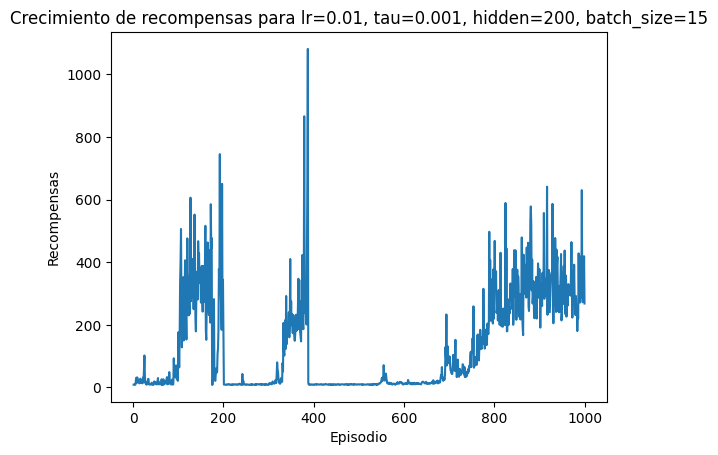

El valor maximo para lr=0.01, tau=0.001, hidden=200, batch_size=15 es: 1081.0


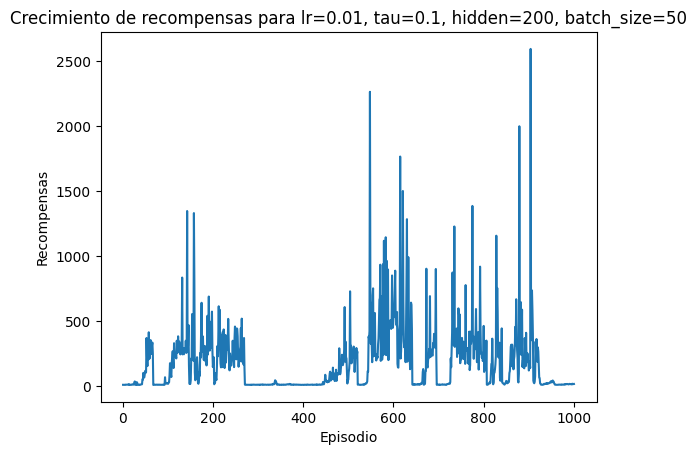

El valor maximo para lr=0.01, tau=0.1, hidden=200, batch_size=50 es: 2593.0


In [16]:
for i, (nombre, rendimientos) in enumerate(resultados_MQL.items()):
    plt.figure(i)
    plt.plot(range(1, len(rendimientos) + 1), rendimientos)
    plt.xlabel('Episodio')
    plt.ylabel('Recompensas')
    plt.title(f'Crecimiento de recompensas para {nombre}')
    plt.show()
    val_max=max(rendimientos)
    print('El valor maximo para {} es: {}'.format(nombre,val_max))

#### Expended SARSA

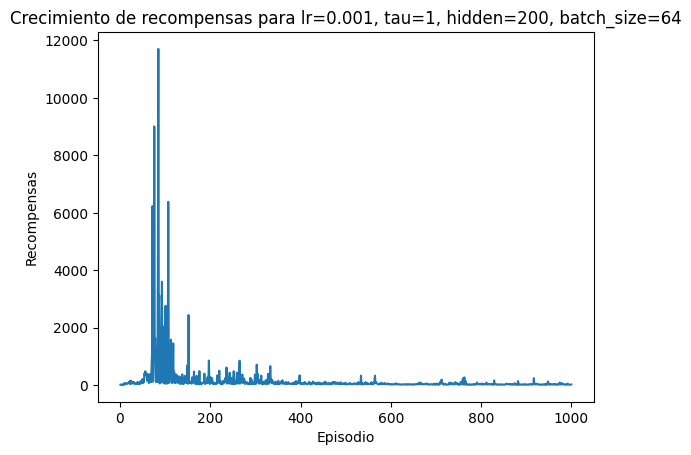

El valor maximo para lr=0.001, tau=1, hidden=200, batch_size=64 es: 11705.0


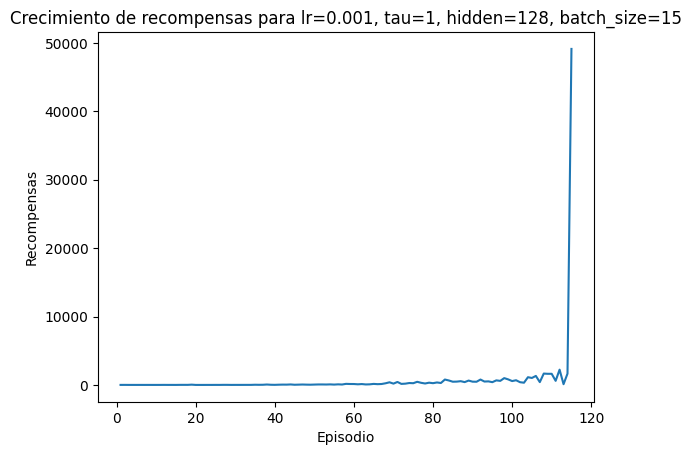

El valor maximo para lr=0.001, tau=1, hidden=128, batch_size=15 es: 49106.0


In [14]:

for i, (nombre, rendimientos) in enumerate(resultados_MES.items()):
    plt.figure(i)
    plt.plot(range(1, len(rendimientos) + 1), rendimientos)
    plt.xlabel('Episodio')
    plt.ylabel('Recompensas')
    plt.title(f'Crecimiento de recompensas para {nombre}')
    plt.show()
    val_max=max(rendimientos)
    print('El valor maximo para {} es: {}'.format(nombre,val_max))

# Conclusiones
A través de nuestro análisis y observaciones de los gráficos generados durante el proyecto, hemos llegado a varias conclusiones significativas. La más notable es la superioridad del algoritmo Expended SARSA sobre Q-learning en la resolución del problema CartPole-v1.

En nuestras pruebas, Expended SARSA alcanzó una recompensa impresionante de 11705.0 con los parámetros lr=0.001, tau=1, hidden=200, batch_size=64. Aún más asombroso fue que con lr=0.001, tau=1, hidden=128, batch_size=15, Expended SARSA logró una meta de 49106.0 en tan solo 120 episodios. Estos resultados destacan la eficacia de Expended SARSA en este contexto.

Por otro lado, Q-learning, aunque es un algoritmo sólido y ampliamente utilizado, no pudo igualar el rendimiento de Expended SARSA en nuestras pruebas. Con lr=0.01, tau=0.001, hidden=200, batch_size=15, Q-learning alcanzó una meta de 1081.0. Incluso con una configuración de parámetros diferente lr=0.01, tau=0.1, hidden=200, batch_size=50, sólo logró una meta de 2593.0.

Estos resultados indican claramente que, en nuestras pruebas, Expended SARSA fue superior a Q-learning para resolver el problema CartPole-v1. Esto subraya la importancia de seleccionar el algoritmo adecuado para el problema en cuestión y de ajustar cuidadosamente los parámetros para obtener el mejor rendimiento posible.

### Mejor rendimiento de Expended SARSA
Expended SARSA puede haber tenido un mejor rendimiento en nuestras pruebas debido a su capacidad para considerar la política actual en su proceso de aprendizaje. A diferencia de Q-learning, que es un algoritmo de aprendizaje por diferencias temporales fuera de la política (off-policy), Expended SARSA es un algoritmo de aprendizaje por diferencias temporales dentro de la política (on-policy). Esto significa que Expended SARSA actualiza sus estimaciones en función de las acciones que realmente se tomarán a continuación, según la política actual. Esto puede permitirle adaptarse más eficazmente a la tarea en cuestión y, en algunos casos, lograr un rendimiento superior.

Sin embargo, esta ventaja viene con un costo. Expended SARSA puede ser computacionalmente más costoso que Q-learning. Esto se debe a que necesita actualizar sus estimaciones para cada posible acción en cada paso, lo que puede ser muy costoso en términos de tiempo y recursos computacionales, especialmente cuando el espacio de acciones es grande. En otras palabras, la complejidad computacional de Expended SARSA crece con el tamaño del espacio de acciones.

Por lo tanto, aunque Expended SARSA puede ser capaz de lograr un rendimiento superior en algunas tareas, es importante tener en cuenta estos trade-offs al seleccionar un algoritmo para un problema específico. En algunos casos, un algoritmo más eficiente en términos computacionales, como Q-learning, puede ser una opción más adecuada.

### Autocrítica
Si bien nuestro proyecto ha logrado resultados significativos, creemos que hay áreas en las que se pudo haber profundizado más. En particular, aunque la experimentación de parámetros fue altamente efectiva, reconozco que no se exploró una inmensa cantidad de combinaciones de parámetros.

El análisis se limitó a observar el rendimiento de los algoritmos en 100 episodios y truncado a 500 pasos. Esto podría haber limitado la capacidad para identificar ciertas combinaciones de parámetros que podrían haber destacado fuera de estos rangos. Es posible que algunas combinaciones de parámetros tengan una menor varianza o puedan alcanzar una meta más alta si se les permite más episodios o pasos.

Además, es importante destacar que los resultados obtenidos con las mejores combinaciones de Q-learning y Expended SARSA se basan en una única ejecución para cada combinación de parámetros. Esto significa que los resultados representan una pequeña muestra que resalta una característica en particular, en lugar de ser la norma. En futuras investigaciones, sería beneficioso realizar múltiples ejecuciones para cada combinación de parámetros para obtener una imagen más precisa del rendimiento esperado.

Reconozco que estas limitaciones podrían haber afectado a los resultados y conclusiones. En futuros trabajos, planeamos expandir nuestro rango de experimentación para incluir una mayor variedad de combinaciones de parámetros y permitir un mayor número de episodios y pasos. Creemos que esto nos permitirá obtener una imagen más completa y precisa del rendimiento de los algoritmos.